In [1]:
import sys
import numpy as np

sys.path.insert(0, "../mlagents")
sys.path.insert(1, "../ddpg")

#from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
#channel = EngineConfigurationChannel()
#channel.set_configuration_parameters(width = 640, height = 480, quality_level = 5)

#from mlagents_envs.environment import UnityEnvironment
from unityagents import UnityEnvironment
#env = UnityEnvironment(file_name='/home/cornelius/mlagents/reacher/Reacher_Linux/Reacher.x86_64')#, screen_width=640, screen_height=480, quality_level=5)
env = UnityEnvironment(file_name='/home/cornelius/mlagents/reacher/Reacher_Linux_NoVis/Reacher.x86_64')#, screen_width=640, screen_height=480, quality_level=5)

#UnityEnvironment._channel = channel
#env._channel = channel
#env.reset()
# get the default brain
brain_name = env.brain_names[0]

brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name] # reset the environment


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Found path: /home/cornelius/mlagents/reacher/Reacher_Linux_NoVis/Reacher.x86_64
Mono path[0] = '/home/cornelius/mlagents/reacher/Reacher_Linux_NoVis/Reacher_Data/Managed'
Mono config path = '/home/cornelius/mlagents/reacher/Reacher_Linux_NoVis/Reacher_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/cornelius/.config/unity3d/Unity Technologies/Unity Environment/Player.log


In [2]:
#hyperparameters, batchnorm1d from https://github.com/BruceChanJianLe/drlnd-reacher-project2/blob/main/ddpg_agent.py
#buffer_size, tau from https://github.com/crazyleg/TD3-reacher


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
import copy


print_every = 10

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay


#, buffer_size=int(1e5), batch_size=256, actor_lr=1e-3, critic_lr=1e-3, weight_decay=0, update_every=1, num_updates=1, gamma=0.9, tau=.001, 

class dppg_agent():
    def __init__(self, state_size, action_size, random_seed, actor_fc1_units=512, actor_fc2_units=512, critic_fcs1_units=512, critic_fc2_units=512, update_every=1, num_updates=1, device="cpu"):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random_seed
        self.actor_fc1_units = actor_fc1_units
        self.actor_fc2_units = actor_fc2_units
        self.critic_fcs1_units = critic_fcs1_units
        self.critic_fc2_units = critic_fc2_units
        self.buffer_size = BUFFER_SIZE
        self.batch_size = BATCH_SIZE
        self.actor_lr = LR_ACTOR
        self.critic_lr = LR_CRITIC
        self.weight_decay = WEIGHT_DECAY
        self.update_every = update_every
        self.num_updates = num_updates
        self.gamma = GAMMA
        self.tau = TAU
        self.device = device
        self.seed = random_seed
        self.actor_local = Actor(state_size, action_size, random_seed, actor_fc1_units, actor_fc2_units).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, actor_fc1_units, actor_fc2_units).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.actor_lr)
        self.critic_local = Critic(state_size, action_size, random_seed, critic_fcs1_units, critic_fc2_units).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, critic_fcs1_units, critic_fc2_units).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.critic_lr, weight_decay=self.weight_decay)
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, random_seed, device)
        self.noise = OUNoise(action_size, random_seed)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                for _ in range(self.num_updates):
                    experiences = self.memory.sample()
                    self.learn(experiences, self.gamma)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        #print ('states.shape: ', states.shape, 'actions.shape: ', actions.shape, 'rewards.shape: ', rewards.shape, 'next_states.shape: ', next_states.shape, 'dones.shape: ', dones.shape)
        actions_next = self.actor_target(next_states)
        #print ('actions_next.shape: ', actions_next.shape)
        Q_targets_next = self.critic_target(next_states, actions_next)
        #print ('rewards.shape: ', rewards.shape, 'Q_targets_next.shape: ', Q_targets_next.shape, 'dones.shape: ', dones.shape)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    def __init__(self, size, seed, mu=0., theta=0.03, sigma=0.02): #theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state
    
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(num_features=fc1_units)        
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        #x = F.normalize(state, dim=-1)
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
#        x = nn.BatchNorm1d(x) # added batch normalization
        return nn.Tanh()(self.fc3(x))
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(num_features=fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(self.bn1(self.fcs1(state)))
        #print ('xs.shape: ', xs.shape, 'action.shape: ', action.shape)
        x = torch.cat((xs, action), dim=1)
        #print ('x.shape: ', x.shape)
#        x = nn.BatchNorm1d(x) # added batch normalization
        x = F.relu(self.fc2(x))
        #print ('x.shape: ', x.shape)
        return self.fc3(x)
    
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        #e = self.experience(state, action, reward, next_state, done)
        #print ('adding: ', len(e.state), len(e.action), len(e.reward), len(e.next_state), len(e.done))
        #print ('e: ', e.state.shape, e.action.shape, e.reward.shape, e.next_state.shape, e.done.shape)

        #for s, a, r, n, d in zip(state, action, reward, next_state, done):
        #     self.memory.append(self.experience(s, a, r, n, d))

        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        #print ('a: states.shape: ', states.shape, 'actions.shape: ', actions.shape, 'rewards.shape: ', rewards.shape, 'next_states.shape: ', next_states.shape, 'dones.shape: ', dones.shape)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)
    
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = dppg_agent(state_size=33, action_size=4, random_seed=2, device=device)

#env_info = env.reset(train_mode=True)[brain_name]      # reset the environment
#state = env_info.vector_observations[0]            # get the current state
scores_window = deque(maxlen=100)  # last 100 scores
avg_score_list = []
n_episodes = 1000
for i_episode in range(1, n_episodes + 1):
    env_info = env.reset(train_mode=True)[brain_name]
    agent.reset()
    state = env_info.vector_observations[0]  / 10.   # get the next state
    #num_agents = len(env_info.agents)  # get number of agents
    #scores = np.zeros(num_agents)  # initialize the score
    scores = 0
    for t in range(1000):
        #print ('t: ', t, 'state: ', state.shape, 'state: ', state)
        action = agent.act(state)                      # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]  / 10.   # get the next state
        reward = env_info.rewards[0]                      # get the reward
        done = env_info.local_done[0]                     # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        scores += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                               # exit loop if episode finished
            break
    scores_window.append(scores)
    avg_score_list.append(np.mean(scores_window))

    print(
        "\rEpisode {}\tCurrent score: {:.2f}, Average score: {:.2f}".format(
            i_episode, scores, np.mean(scores_window)
        ))

    if np.mean(scores_window) >= 30.0:
        print(
            "\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}".format(
                i_episode - 100, np.mean(scores_window)
            )
        )
        torch.save(agent.actor_local.state_dict(), "checkpoint_actor.pth")
        torch.save(agent.critic_local.state_dict(), "checkpoint_critic.pth")
        break

env.close()


    

/home/cornelius/anaconda3/envs/mlagents/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Episode 1	Current score: 0.81, Average score: 0.81
Episode 2	Current score: 0.33, Average score: 0.57
Episode 3	Current score: 1.23, Average score: 0.79
Episode 4	Current score: 1.07, Average score: 0.86
Episode 5	Current score: 1.17, Average score: 0.92
Episode 6	Current score: 4.22, Average score: 1.47
Episode 7	Current score: 0.79, Average score: 1.37
Episode 8	Current score: 1.71, Average score: 1.42
Episode 9	Current score: 1.06, Average score: 1.38
Episode 10	Current score: 0.81, Average score: 1.32
Episode 11	Current score: 1.38, Average score: 1.33
Episode 12	Current score: 1.50, Average score: 1.34
Episode 13	Current score: 1.45, Average score: 1.35
Episode 14	Current score: 1.30, Average score: 1.34
Episode 15	Current score: 3.07, Average score: 1.46
Episode 16	Current score: 2.11, Average score: 1.50
Episode 17	Current score: 2.00, Average score: 1.53
Episode 18	Current score: 1.42, Average score: 1.52
Episode 19	Current score: 1.36, Average score: 1.52
Episode 20	Current sc

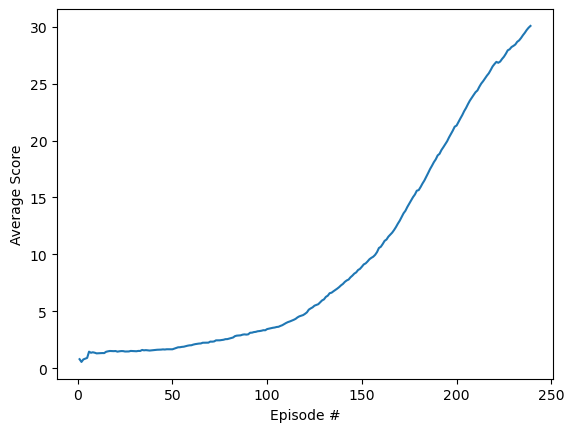

In [3]:
# plot the scores
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(avg_score_list) + 1), avg_score_list)
plt.ylabel("Average Score")
plt.xlabel("Episode #")
plt.show()
